[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laksh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laksh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laksh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


 Welcome to Budget Food Recommendation System
Fetching location coordinates...
Scraping Swiggy restaurant data...
Scraping Zomato restaurant data...
Ranking restaurants...

 Top Recommended Restaurants:
1. KFC (Unison Mall) | ₹400 |  4.4 | ['Burgers', 'Fast Food', 'Rolls & Wraps']
   → Distance: 2.0 km | Score: 0.754

2. Burger King (Karanpur) | ₹350 |  4.4 | ['Burgers', 'American']
   → Distance: 2.0 km | Score: 0.754

3. Burgrill - The Win Win Burger (Rajpur Road) | ₹250 |  4.4 | ['Salads', 'Desserts', 'Continental', 'Beverages', 'American']
   → Distance: 2.0 km | Score: 0.754

4. KFC (Unison Mall) | ₹400 |  4.4 | ['Burgers', 'Fast Food', 'Rolls & Wraps']
   → Distance: 2.0 km | Score: 0.754

5. Burger King (Karanpur) | ₹350 |  4.4 | ['Burgers', 'American']
   → Distance: 2.0 km | Score: 0.754

6. McDonald's (Karanpur) | ₹400 |  4.5 | ['American']
   → Distance: 2.0 km | Score: 0.564

7. McDonald's (Karanpur) | ₹400 |  4.5 | ['American']
   → Distance: 2.0 km | Score: 0.564

8. Pizz

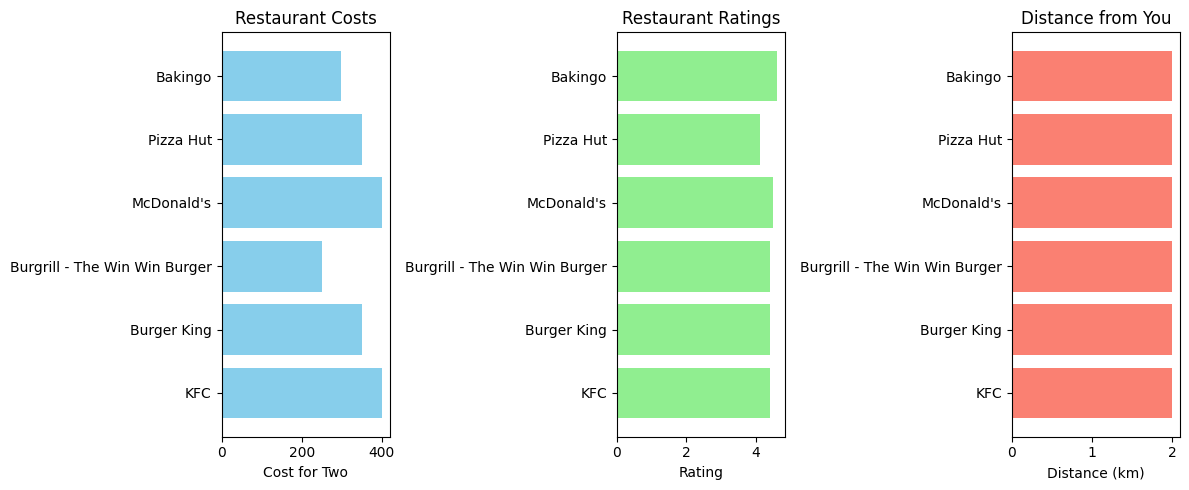

In [ ]:
import requests
import torch
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from sentence_transformers import SentenceTransformer, util
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import time
import sys
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
model = SentenceTransformer('all-MiniLM-L6-v2')
geolocator = Nominatim(user_agent="food-recommender")

def normalize_food_name(text):
    text = text.lower()
    tokens = word_tokenize(text)
    cleaned = [lemmatizer.lemmatize(t) for t in tokens if t.isalpha() and t not in stop_words]
    return " ".join(cleaned)

def get_lat_lon(city_name):
    location = geolocator.geocode(city_name)
    if not location:
        raise ValueError("Invalid city name. Please enter a recognizable city.")
    return (location.latitude, location.longitude, city_name)

def get_swiggy_data(lat, lon):
    url = f"https://www.swiggy.com/dapi/restaurants/list/v5?lat={lat}&lng={lon}&is-seo-homepage-enabled=true&page_type=DESKTOP_WEB_LISTING"
    headers = {"User-Agent": "Mozilla/5.0"}
    try:
        res = requests.get(url, headers=headers, timeout=10)
        data = res.json()
        cards = data.get('data', {}).get('cards', [])
        restaurants = []
        for card in cards:
            try:
                restaurants += card['card']['card']['gridElements']['infoWithStyle']['restaurants']
            except KeyError:
                continue
        return restaurants
    except Exception as e:
        print("⚠️ Error fetching data from Swiggy:", e)
        return []

def get_zomato_data(city_name):
    try:
        url = f"https://www.zomato.com/{city_name.lower().replace(' ', '-')}/restaurants"
        headers = {"User-Agent": "Mozilla/5.0"}
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')

        zomato_restaurants = []
        listings = soup.find_all('div', {'class': 'sc-clNaTc cCUpbB'})
        for item in listings:
            try:
                name = item.find('h4').text.strip()
                cuisines = item.find('p').text.strip().split(', ')
                zomato_restaurants.append({
                    'name': name,
                    'area': city_name,
                    'rating': 4.0,
                    'cuisines': cuisines,
                    'cost_for_two': 300,
                    'distance_km': 2.0,
                    'score': 0.0
                })
            except:
                continue
        return zomato_restaurants
    except Exception as e:
        print("⚠️ Error fetching data from Zomato:", e)
        return []

def plot_charts(results):
    names = [res['name'] for res in results]
    costs = [res['cost_for_two'] for res in results]
    ratings = [res['rating'] for res in results]
    distances = [res['distance_km'] for res in results]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.barh(names, costs, color='skyblue')
    plt.xlabel('Cost for Two')
    plt.title('Restaurant Costs')

    plt.subplot(1, 3, 2)
    plt.barh(names, ratings, color='lightgreen')
    plt.xlabel('Rating')
    plt.title('Restaurant Ratings')

    plt.subplot(1, 3, 3)
    plt.barh(names, distances, color='salmon')
    plt.xlabel('Distance (km)')
    plt.title('Distance from You')

    plt.tight_layout()
    plt.show()

def filter_and_rank_restaurants(restaurants, user_food, budget, user_coords):
    user_embedding = model.encode(normalize_food_name(user_food), convert_to_tensor=True)
    results = []

    for res in restaurants:
        name = res.get('name', '')
        cuisines = res.get('cuisines', [])
        if not cuisines:
            continue

        rating = res.get('rating', 0.0)
        cost = res.get('cost_for_two', 300)
        area = res.get('area', '')
        distance_km = res.get('distance_km', 2.0)

        if budget != 1 and cost > budget + 50:
            continue

        food_lower = user_food.lower()
        cuisine_str = " ".join(cuisines).lower()
        name_lower = name.lower()

        if food_lower in cuisine_str or food_lower in name_lower:
            match_score = 1.0
        else:
            combined_text = cuisine_str + " " + name_lower
            food_embedding = model.encode(normalize_food_name(combined_text), convert_to_tensor=True)
            match_score = util.pytorch_cos_sim(user_embedding, food_embedding).item()

        if match_score < 0.15:
            continue

        final_score = (
            0.5 * match_score +
            0.25 * (rating / 5) +
            0.1 * (1 / (1 + distance_km)) +
            0.15 * (1 / (1 + cost))
        )

        res['score'] = round(final_score, 3)
        results.append(res)

    results.sort(key=lambda x: x['score'], reverse=True)
    return results[:10]

if __name__ == '__main__':
    print(" Welcome to Budget Food Recommendation System")

    try:
        city = input("Enter your city: ").strip()
        food = input("Enter the food you want to eat: ").strip()
        budget = int(input("Enter your budget in ₹ (Enter 1 for no budget limit): ").strip())
    except ValueError:
        print("❌ Invalid input. Please enter correct values.")
        sys.exit()

    print("Fetching location coordinates...")
    try:
        lat, lon, city_name = get_lat_lon(city)
    except Exception as e:
        print("❌ Error getting location:", e)
        sys.exit()
    time.sleep(1)

    print("Scraping Swiggy restaurant data...")
    swiggy_restaurants_raw = get_swiggy_data(lat, lon)
    swiggy_restaurants = []
    for info in swiggy_restaurants_raw:
        try:
            swiggy_restaurants.append({
                'name': info['info']['name'],
                'area': info['info']['areaName'],
                'rating': float(info['info'].get('avgRating', 0.0)),
                'cuisines': info['info'].get('cuisines', []),
                'cost_for_two': int(''.join(filter(str.isdigit, info['info'].get('costForTwo', '₹300')))) or 300,
                'distance_km': 2.0,
                'score': 0.0
            })
        except:
            continue

    print("Scraping Zomato restaurant data...")
    zomato_restaurants = get_zomato_data(city_name)

    all_restaurants = swiggy_restaurants + zomato_restaurants

    print("Ranking restaurants...")
    top_matches = filter_and_rank_restaurants(all_restaurants, food, budget, (lat, lon, city_name))

    print("\n Top Recommended Restaurants:")
    if not top_matches:
        print("No matching restaurants found. Try increasing your budget or using a more general food name.")
    for idx, res in enumerate(top_matches, start=1):
        print(f"{idx}. {res['name']} ({res['area']}) | ₹{res['cost_for_two']} |  {res['rating']} | {res['cuisines']}")
        print(f"   → Distance: {res['distance_km']} km | Score: {res['score']}\n")

    if top_matches:
        plot_charts(top_matches)
